### Extract glider section from LLC4320 

In [11]:
import xarray as xr
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_dataset('LLC4320_pre-SWOT_ACC_SMST_20111221.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:   (j_g: 349, i: 192, i_g: 192, j: 349, k: 84, k_u: 84, k_l: 84, k_p1: 85, nb: 2, time: 24)
Coordinates:
  * j_g       (j_g) float32 0.0 1.0 2.0 3.0 4.0 ... 345.0 346.0 347.0 348.0
  * i         (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0
  * i_g       (i_g) float32 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * j         (j) float32 0.0 1.0 2.0 3.0 4.0 ... 344.0 345.0 346.0 347.0 348.0
  * k         (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 74 75 76 77 78 79 80 81 82 83
  * k_u       (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * k_l       (k_l) int32 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * k_p1      (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 75 76 77 78 79 80 81 82 83 84
  * nb        (nb) int32 0 1
  * time      (time) datetime64[ns] 2011-12-21 ... 2011-12-21T23:00:00
Data variables: (12/35)
    XC        (j, i) float32 ...
    YC        (j, i) float32 ...
    DXV       (j, i) float32 ...
    DYU       (j, i) float32 ...
    Depth     (j, i) float32 ...
    AngleSN   (j, i) float32 ...
    ...        ...
    oceTAUY   (time, j_g, i) float64 ...
    Theta     (time, k, j, i) float64 ...
    Salt      (time, k, j, i) float64 ...
    U         (time, k, j, i_g) float32 ...
    V         (time, k, j_g, i) float64 ...
    W         (time, k_l, j, i) float64 ...
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2011-12-21 23:00:00
    time_coverage_start:             2011-12-21 00:00:00
    title:                           LLC4320 regional Southern Ocean
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

There are two tasks that need to be dealt with here: 
- LLC4320 data does not have lat-lon etc as a coordinate, instead the coordinates are simply index numbers. This means that the lon-lat-depth passed for the trajectory have to be converted to the corresponding index numbers first (which will not be integers). (This is annoying!)
- These interpolated "index numbers" will then be used to extract data on points. 

#### Coordinates to "index numbers"


In [6]:
# try for Z first as that 1d. 

z = ds.Z
k = ds.k

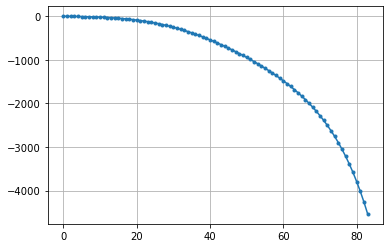

In [16]:
plt.plot(k, z, '.-')
plt.grid()

In [14]:
f_z = interpolate.interp1d(z, k)

In [26]:
X = ds.XC
Y = ds.YC

In [36]:
i = ds.i
j = ds.j

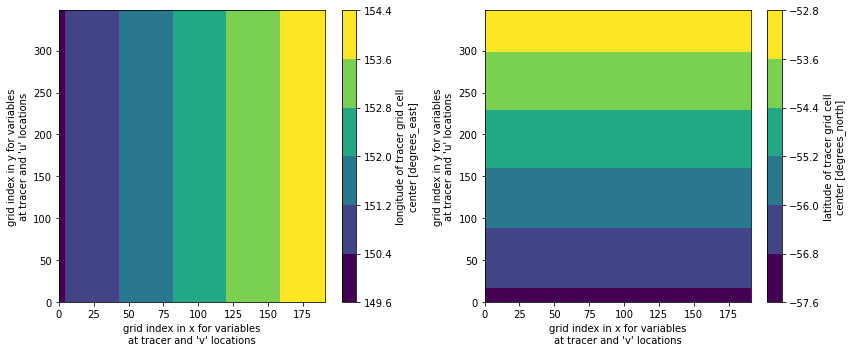

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
X.plot.contourf()

plt.subplot(122)
Y.plot.contourf()

plt.tight_layout()

In [44]:
X.diff('j')

<xarray.DataArray 'XC' (j: 348, i: 192)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * i        (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0
  * j        (j) float32 1.0 2.0 3.0 4.0 5.0 ... 344.0 345.0 346.0 347.0 348.0

In [45]:
Y.diff('i')

<xarray.DataArray 'YC' (j: 349, i: 191)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * i        (i) float32 1.0 2.0 3.0 4.0 5.0 ... 187.0 188.0 189.0 190.0 191.0
  * j        (j) float32 0.0 1.0 2.0 3.0 4.0 ... 344.0 345.0 346.0 347.0 348.0

It seems like (atleast for this region) the LLC grids are linear, meaning that every i value has only one X associated with. This implies that the grid is not curved relative to i and j. This makes life much easier.

In [38]:
f_x = interpolate.interp1d(X[0,:].values, i)
f_y = interpolate.interp1d(Y[:,0].values, j)

Now that we have the required functions to go from lon, lat, z to the indices i,j,k, we can move forward. 

In [65]:
print(X.min(), X.max())
print(Y.min(), Y.max())

<xarray.DataArray 'XC' ()>
array(150.30207825) <xarray.DataArray 'XC' ()>
array(154.28125)
<xarray.DataArray 'YC' ()>
array(-56.98995209) <xarray.DataArray 'YC' ()>
array(-53.00566864)


[Text(0, 0.5, 'lat')]

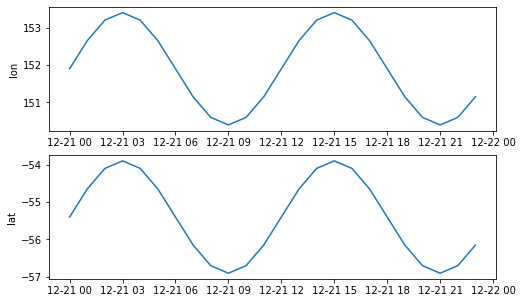

In [85]:
# 150 to 154
# -57 to -53

n = ds.time.size # number of time points
ncycle = 2 # number of crossings
A = 3 # amplitude of the crossings

# create survey data
survey = xr.Dataset(
    dict(
        lon = xr.DataArray(A*(np.sin(2*np.pi*np.arange(n)/(n/ncycle))+1)/2 + 150.4,dims='points'),
        lat = xr.DataArray(A*(np.sin(2*np.pi*np.arange(n)/(n/ncycle))+1)/2 - 56.9,dims='points'),
        time = xr.DataArray(ds.time.data,dims='points'),
    )
)

# plot survey lon and lat with time
fig,ax = plt.subplots(2,1,figsize=(8,5))
ax[0].plot(survey.time,survey.lon)
ax[1].plot(survey.time,survey.lat)
ax[0].set(ylabel='lon')
ax[1].set(ylabel='lat')


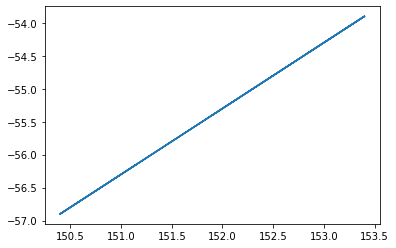

In [86]:
plt.plot(survey.lon, survey.lat)

In [87]:
survey_indices= xr.Dataset(
    dict(
        i = xr.DataArray(f_x(survey.lon), dims='points'),
        j = xr.DataArray(f_y(survey.lat), dims='points'),
        k = xr.DataArray(0*np.zeros_like(survey.lon.data), dims='points'),
        time = xr.DataArray(ds.time.data,dims='points'),
    )
)

In [88]:
survey_indices

<xarray.Dataset>
Dimensions:  (points: 24)
Dimensions without coordinates: points
Data variables:
    i        (points) float64 76.7 112.7 139.1 148.7 ... 14.35 4.7 14.35 40.7
    j        (points) float64 142.1 207.7 255.1 272.3 ... 8.118 26.22 75.45
    k        (points) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    time     (points) datetime64[ns] 2011-12-21 ... 2011-12-21T23:00:00

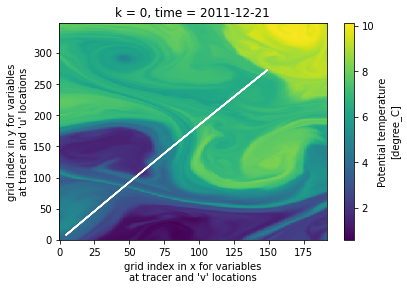

In [91]:
ds.Theta.isel(k=0, time=0).plot()
plt.plot(survey_indices.i, survey_indices.j, color='w')

In [82]:
theta_points = ds.Theta.interp(survey_indices)

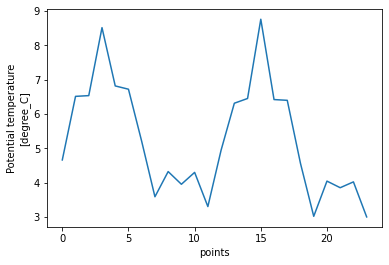

In [84]:
theta_points.plot()